In [320]:
#Imports and API Key
#building in offsets

#Imports and API Key

import pandas as pd
import quandl
from scipy import stats
import scipy
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

import numpy as np
import sys

from sklearn.pipeline import Pipeline

from basis_expansions.basis_expansions import (
    Polynomial, LinearSpline)

from regression_tools.dftransformers import (
    ColumnSelector, Identity, FeatureUnion, MapFeature, Intercept)

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeClassifier

import seaborn as sns

from sklearn.linear_model import LinearRegression


import xgboost as xgb

%aimport dataclean

quandl.ApiConfig.api_key = 'm8FYMyoCaJSbTrBASNHh'

In [321]:
#pulling data from Quandl

data = pd.read_csv('datasources2.csv') #staging the QUANDL keys to pull in CSV
cols = list(data['Var_name'].astype('str'))
dataset = quandl.get([val for val in data['Quandl Key']]) #looping through the QUANDL keys to pull it into one DF
dataset.columns = cols

In [322]:
#pd.datetime(2018,1,1)-pd.DateOffset(years=1)

In [323]:
#pulling FED Yield Curve data

yields = pd.read_csv('Fed10Y_3M.csv')
yields['Date'] = pd.to_datetime(yields['Date'])
mask = (yields['Date'] > pd.datetime(2058,1,1))
yields.loc[mask,'Date'] = yields.loc[mask,'Date'].apply(lambda x: x - pd.DateOffset(years=100))

yields['Date'] = yields['Date'].apply(lambda x: x.strftime('%Y-%m'))

yields = yields.set_index('Date')
yields = yields.drop(['3 Month Treasury Yield', 'Rec_prob', 'NBER_Rec'], axis=1) 

In [324]:
yields

,10 Year Treasury Yield,3 Month Treasury Yield (Bond Equivalent Basis),Spread
Date,,,
1959-01,4.02,2.88,1.14
1959-02,3.96,2.76,1.20
1959-03,3.99,2.86,1.13
1959-04,4.12,3.01,1.11
1959-05,4.31,2.90,1.41
1959-06,4.34,3.28,1.06
1959-07,4.40,3.27,1.13
1959-08,4.43,3.46,0.97
1959-09,4.68,4.14,0.54


In [325]:
yields

,10 Year Treasury Yield,3 Month Treasury Yield (Bond Equivalent Basis),Spread
Date,,,
1959-01,4.02,2.88,1.14
1959-02,3.96,2.76,1.20
1959-03,3.99,2.86,1.13
1959-04,4.12,3.01,1.11
1959-05,4.31,2.90,1.41
1959-06,4.34,3.28,1.06
1959-07,4.40,3.27,1.13
1959-08,4.43,3.46,0.97
1959-09,4.68,4.14,0.54


In [326]:
#need to write in special logic to factor in for 3YRT being a daily

treas = dataset['3YRT']
dataset = dataset.drop(columns = ['3YRT'])

In [327]:
treas = treas.resample('MS').mean()

In [328]:
## back to working on the general data
dataset.index = dataset.index.strftime('%Y-%m') #converting the datetime index to Y/M so it is collapsable
dataset = dataset.groupby(dataset.index, as_index=True).agg(sum) #collapsing by Y/M

In [329]:
#readd 3YRT back into data

dataset = dataset.join(treas, how='outer')

In [330]:
#converting GDP quarterly data into monthly - need to convert it so it fills in the following 3 months

dataset = dataclean.convert_q_to_m(dataset, 'GDP')

#converting consumer sentiment into monthly

dataset = dataclean.convert_q_to_m(dataset, 'CONS_SENT')

In [331]:
offset_dict = {'PMI':1, 'UNR':1, 'YUNR':1,'US_NHOME_SALES':1, 'PART_TIME':1, 'CPPR_PRICE':1, 'HOUS_PERMS':1, 'HOUS_STARTS':1, 'CAP_UTIL':1, 'PERS_SAVINGS':3, 'EXPORTS':3, 'IMPORTS':3, 'TRADE_BALANCE':3, 'US_M2':1, 'US_NHOME_SALES':1,'PPI':1,'CPI':1} #positives shift down, negatives shift up. Goal of this dict is to align data to when it gets released

In [332]:
for entry in offset_dict:
    #print(entry)
    #print(offset_dict[entry])
    dataset[str(entry)] = dataset[str(entry)].shift(offset_dict[entry])

In [333]:
#calculating change in GDP and converting Y into categorical values 
dataset['GDP_Delta'] = ((dataset['GDP'] - dataset['GDP'].shift(3)) < 0)
#dataset = dataset.drop(columns = ['GDP','Recession']) #dropping calc column and recession column from dataset, experimenting with taking out fed funds rate

In [334]:
#merge fed interest rate data here
dataset = dataset.join(yields, how='outer')

In [335]:
dataset.shape

(1287, 24)

In [336]:
dataset = dataset[552:]

In [337]:
dataset = dataset[:-12]

In [338]:
#substituting mean value in for missing values and adding dummy column to indicate where done

for col in dataset.columns:
    if str(col)=='GDP_Delta':
        continue
    dataclean.clean_zeros(col, dataset)

In [339]:
dataset['3YRT'] = dataset['3YRT'].fillna(dataset['3YRT'].mean())

In [340]:
dataset.head()

,PMI,UNR,YUNR,CONS_SENT,PART_TIME,CPPR_PRICE,HOUS_PERMS,HOUS_STARTS,CAP_UTIL,PERS_SAVINGS,EXPORTS,IMPORTS,TRADE_BALANCE,INT_RATE,US_M2,US_NHOME_SALES,PPI,CPI,GDP,3YRT,GDP_Delta,10 Year Treasury Yield,3 Month Treasury Yield (Bond Equivalent Basis),Spread,CPPR_PRICE_PXY,HOUS_PERMS_PXY,HOUS_STARTS_PXY,CAP_UTIL_PXY,PERS_SAVINGS_PXY,US_M2_PXY,US_NHOME_SALES_PXY,CPI_PXY
1959-01-01,60.5,6.2,12.1,90.8,1081.0,165.378976,1331.172891,1429.161826,69.493464,8.777593,1349.0,1091.0,258.0,2.48,4043.176487,606.114799,31.6,13.253507,3121.936,5.567476,False,4.02,2.88,1.14,1,1,1,1,1,1,1,0
1959-02-01,64.4,6.0,11.6,90.8,1022.0,165.378976,1331.172891,1657.000000,69.493464,8.777593,1401.0,1156.0,245.0,2.43,286.600000,606.114799,31.7,13.299366,3121.936,5.567476,False,3.96,2.76,1.20,1,1,0,1,1,0,1,0
1959-03-01,66.9,5.9,11.1,90.8,973.0,165.378976,1331.172891,1667.000000,69.493464,8.777593,1339.0,1139.0,200.0,2.80,287.700000,606.114799,31.7,13.253507,3121.936,5.567476,False,3.99,2.86,1.13,1,1,0,1,1,0,1,0
1959-04-01,67.1,5.6,11.1,90.8,1102.0,165.378976,1331.172891,1620.000000,69.493464,11.300000,1314.0,1166.0,148.0,2.96,289.200000,606.114799,31.7,13.253507,3192.380,5.567476,False,4.12,3.01,1.11,1,1,0,1,0,0,1,0
1959-05-01,66.9,5.2,10.8,95.3,1086.0,165.378976,1331.172891,1590.000000,69.493464,10.600000,1256.0,1202.0,54.0,2.90,290.100000,606.114799,31.8,13.299366,3192.380,5.567476,False,4.31,2.90,1.41,1,1,0,1,0,0,1,0


In [341]:
#adding momentum factors

momentum_cols = list(dataset.columns[:-6])

momentum_cols.remove('PPI') #removing PPI and CPI because they need a different transformation
momentum_cols.remove('CPI')
momentum_cols.remove('GDP_Delta')

for i in [1,3,12]:
    for col in momentum_cols:
        dataclean.create_momentum(col,dataset,i)

In [342]:
#CPI Calcs

for i in [1,3,12]:
    for col in ['CPI','PPI']:
        dataclean.infl_momentum(col,dataset,i)

In [343]:
pd.set_option('display.max_columns', None)
dataset.head()

,PMI,UNR,YUNR,CONS_SENT,PART_TIME,CPPR_PRICE,HOUS_PERMS,HOUS_STARTS,CAP_UTIL,PERS_SAVINGS,EXPORTS,IMPORTS,TRADE_BALANCE,INT_RATE,US_M2,US_NHOME_SALES,PPI,CPI,GDP,3YRT,GDP_Delta,10 Year Treasury Yield,3 Month Treasury Yield (Bond Equivalent Basis),Spread,CPPR_PRICE_PXY,HOUS_PERMS_PXY,HOUS_STARTS_PXY,CAP_UTIL_PXY,PERS_SAVINGS_PXY,US_M2_PXY,US_NHOME_SALES_PXY,CPI_PXY,PMI_1m_shift,UNR_1m_shift,YUNR_1m_shift,CONS_SENT_1m_shift,PART_TIME_1m_shift,CPPR_PRICE_1m_shift,HOUS_PERMS_1m_shift,HOUS_STARTS_1m_shift,CAP_UTIL_1m_shift,PERS_SAVINGS_1m_shift,EXPORTS_1m_shift,IMPORTS_1m_shift,TRADE_BALANCE_1m_shift,INT_RATE_1m_shift,US_M2_1m_shift,US_NHOME_SALES_1m_shift,GDP_1m_shift,3YRT_1m_shift,10 Year Treasury Yield_1m_shift,3 Month Treasury Yield (Bond Equivalent Basis)_1m_shift,Spread_1m_shift,CPPR_PRICE_PXY_1m_shift,HOUS_PERMS_PXY_1m_shift,PMI_3m_shift,UNR_3m_shift,YUNR_3m_shift,CONS_SENT_3m_shift,PART_TIME_3m_shift,CPPR_PRICE_3m_shift,HOUS_PERMS_3m_shift,HOUS_STARTS_3m_shift,CAP_UTIL_3m_shift,PERS_SAVINGS_3m_shift,EXPORTS_3m_shift,IMPORTS_3m_shift,TRADE_BALANCE_3m_shift,INT_RATE_3m_shift,US_M2_3m_shift,US_NHOME_SALES_3m_shift,GDP_3m_shift,3YRT_3m_shift,10 Year Treasury Yield_3m_shift,3 Month Treasury Yield (Bond Equivalent Basis)_3m_shift,Spread_3m_shift,CPPR_PRICE_PXY_3m_shift,HOUS_PERMS_PXY_3m_shift,PMI_12m_shift,UNR_12m_shift,YUNR_12m_shift,CONS_SENT_12m_shift,PART_TIME_12m_shift,CPPR_PRICE_12m_shift,HOUS_PERMS_12m_shift,HOUS_STARTS_12m_shift,CAP_UTIL_12m_shift,PERS_SAVINGS_12m_shift,EXPORTS_12m_shift,IMPORTS_12m_shift,TRADE_BALANCE_12m_shift,INT_RATE_12m_shift,US_M2_12m_shift,US_NHOME_SALES_12m_shift,GDP_12m_shift,3YRT_12m_shift,10 Year Treasury Yield_12m_shift,3 Month Treasury Yield (Bond Equivalent Basis)_12m_shift,Spread_12m_shift,CPPR_PRICE_PXY_12m_shift,HOUS_PERMS_PXY_12m_shift,CPI_1m_shift,PPI_1m_shift,CPI_3m_shift,PPI_3m_shift,CPI_12m_shift,PPI_12m_shift
1959-01-01,60.5,6.2,12.1,90.8,1081.0,165.378976,1331.172891,1429.161826,69.493464,8.777593,1349.0,1091.0,258.0,2.48,4043.176487,606.114799,31.6,13.253507,3121.936,5.567476,False,4.02,2.88,1.14,1,1,1,1,1,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-02-01,64.4,6.0,11.6,90.8,1022.0,165.378976,1331.172891,1657.000000,69.493464,8.777593,1401.0,1156.0,245.0,2.43,286.600000,606.114799,31.7,13.299366,3121.936,5.567476,False,3.96,2.76,1.20,1,1,0,1,1,0,1,0,3.9,-0.2,-0.5,0.0,-59.0,0.0,0.0,227.838174,0.0,0.000000,52.0,65.0,-13.0,-0.05,-3756.576487,0.0,0.000,0.0,-0.06,-0.12,0.06,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.346021,0.316456,NaN,NaN,NaN,NaN
1959-03-01,66.9,5.9,11.1,90.8,973.0,165.378976,1331.172891,1667.000000,69.493464,8.777593,1339.0,1139.0,200.0,2.80,287.700000,606.114799,31.7,13.253507,3121.936,5.567476,False,3.99,2.86,1.13,1,1,0,1,1,0,1,0,2.5,-0.1,-0.5,0.0,-49.0,0.0,0.0,10.000000,0.0,0.000000,-62.0,-17.0,-45.0,0.37,1.100000,0.0,0.000,0.0,0.03,0.10,-0.07,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.344828,0.000000,NaN,NaN,NaN,NaN
1959-04-01,67.1,5.6,11.1,90.8,1102.0,165.378976,1331.172891,1620.000000,69.493464,11.300000,1314.0,1166.0,148.0,2.96,289.200000,606.114799,31.7,13.253507,3192.380,5.567476,False,4.12,3.01,1.11,1,1,0,1,0,0,1,0,0.2,-0.3,0.0,0.0,129.0,0.0,0.0,-47.000000,0.0,2.522407,-25.0,27.0,-52.0,0.16,1.500000,0.0,70.444,0.0,0.13,0.15,-0.02,0.0,0.0,6.6,-0.6,-1.0,0.0,21.0,0.0,0.0,190.838174,0.0,2.522407,-35.0,75.0,-110.0,0.48,-3753.976487,0.0,70.444,0.0,0.10,0.13,-0.03,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [344]:
#spline time - splines seriously impede the model, Time Horizon of 1 goes from LL of 4.9 to 8.19, AUC degreades by .04
#stickiness remains

#individual splines


PMI_fit = Pipeline([
    ('PMI', ColumnSelector(name='PMI')),
    ('PMI_spline', LinearSpline(knots=[44,45,47,48]))
])

CONS_SENT_fit = Pipeline([
    ('CONS_SENT', ColumnSelector(name='CONS_SENT')),
    ('CONS_SENT_spline', LinearSpline(knots=[64,68,72,75]))
])

INT_RATE_fit = Pipeline([
    ('INT_RATE', ColumnSelector(name='INT_RATE')),
    ('INT_RATE_spline', LinearSpline(knots=[8.75]))
])

US_NHOME_SALES_fit = Pipeline([
    ('US_NHOME_SALES', ColumnSelector(name='US_NHOME_SALES')),
    ('US_NHOME_SALES_spline', LinearSpline(knots=[450,475,500]))
])

THREE_YRT_fit = Pipeline([
    ('3YRT', ColumnSelector(name='3YRT')),
    ('3YRT_spline', LinearSpline(knots=[11.5]))
])

Spread_fit = Pipeline([
    ('Spread', ColumnSelector(name='Spread')),
    ('Spread_spline', LinearSpline(knots=[-0.1]))
])

CONS_SENT_1m_shift_fit = Pipeline([
    ('CONS_SENT_1m_shift', ColumnSelector(name='CONS_SENT_1m_shift')),
    ('CONS_SENT_1m_shift_spline', LinearSpline(knots=[-5]))
])


CAP_UTIL_1m_shift_fit = Pipeline([
    ('CAP_UTIL_1m_shift', ColumnSelector(name='CAP_UTIL_1m_shift')),
    ('CAP_UTIL_1m_shift_spline', LinearSpline(knots=[-0.5,-0.35,-0.25]))
])

THREE_YRT_1m_shift_fit = Pipeline([
    ('3YRT_1m_shift', ColumnSelector(name='3 YRT_1m_shift')),
    ('3YRT_1m_shift_spline', LinearSpline(knots=[-0.48,-0.46]))
])

THREE_MTREAS_YIELD_1m_shift_fit = Pipeline([
    ('3 Month Treasury Yield (Bond Equivalent Basis)_1m_shift', ColumnSelector(name='3 Month Treasury Yield (Bond Equivalent Basis)_1m_shift')),
    ('3 Month Treasury Yield (Bond Equivalent Basis)_1m_shift_spline', LinearSpline(knots=[-0.625,-0.45]))
])

PMI_3m_shift_fit = Pipeline([
    ('PMI_3m_shift', ColumnSelector(name='PMI_3m_shift')),
    ('PMI_3m_shift_spline', LinearSpline(knots=[-6.5,-5.5,-5.25,-3]))
])

UNR_3m_shift_fit = Pipeline([
    ('UNR_3m_shift', ColumnSelector(name='UNR_3m_shift')),
    ('UNR_3m_shift_spline', LinearSpline(knots=[0.1,0.4]))
])

YUNR_3m_shift_fit = Pipeline([
    ('YUNR_3M_SHIFT', ColumnSelector(name='YUNR_3m_shift')),
    ('YUNR_3M_SHIFT_spline', LinearSpline(knots=[0.5,1]))
])

CONS_SENT_3m_shift_fit = Pipeline([
    ('CONS_SENT_3m_shift', ColumnSelector(name='CONS_SENT_3m_shift')),
    ('CONS_SENT_3m_shift_spline', LinearSpline(knots=[-7,-4.5]))
])

CAP_UTIL_3m_shift_fit = Pipeline([
    ('CAP_UTIL_3m_shift', ColumnSelector(name='CAP_UTIL_3m_shift')),
    ('CAP_UTIL_3m_shift_spline', LinearSpline(knots=[-1.6,-1.5,-1,-0.9]))
])

THREE_MTREAS_YIELD_3m_shift_fit = Pipeline([
    ('3 Month Treasury Yield (Bond Equivalent Basis)_3m_shift', ColumnSelector(name='3 Month Treasury Yield (Bond Equivalent Basis)_3m_shift')),
    ('3 Month Treasury Yield (Bond Equivalent Basis)_3m_shift_spline', LinearSpline(knots=[-1.4]))
])

UNR_12m_shift_fit = Pipeline([
    ('UNR_12m_shift', ColumnSelector(name='UNR_12m_shift')),
    ('UNR_12m_shift_spline', LinearSpline(knots=[2.5,3]))
])

CONS_SENT_12m_shift_fit = Pipeline([
    ('CONS_SENT_12m_shift', ColumnSelector(name='CONS_SENT_12m_shift')),
    ('CONS_SENT_12m_shift_spline', LinearSpline(knots=[-15,-12,-11]))
])

HOUS_PERMS_12m_shift_fit = Pipeline([
    ('HOUS_PERMS_12m_shift', ColumnSelector(name='HOUS_PERMS_12m_shift')),
    ('HOUS_PERMS_12m_shift_spline', LinearSpline(knots=[-375,-300,-200]))
])

HOUS_STARTS_12m_shift_fit = Pipeline([
    ('HOUS_STARTS_12m_shift', ColumnSelector(name='HOUS_STARTS_12m_shift')),
    ('HOUS_STARTS_12m_shift_spline', LinearSpline(knots=[-375,-300]))
])

THREE_YRT_12m_shift_fit = Pipeline([
    ('THREE_YRT_12m_shift', ColumnSelector(name='3YRT_12m_shift')),
    ('THREE_YRT_12m_shift_spline', LinearSpline(knots=[1.75]))
])

TEN_YRT_YIELD_12m_shift_fit = Pipeline([
    ('TEN_YRT_YIELD_12m_shift', ColumnSelector(name='10 Year Treasury Yield_12m_shift')),
    ('10 Year Treasury Yield_12m_shift_spline', LinearSpline(knots=[1.2,1.6]))
])

Spread_12m_shift_fit = Pipeline([
    ('Spread_12m_shift', ColumnSelector(name='Spread_12m_shift')),
    ('Spread_12m_shift_spline', LinearSpline(knots=[1,1.1]))
])

PPI_1m_shift_fit = Pipeline([
    ('PPI_1m_shift', ColumnSelector(name='PPI_1m_shift')),
    ('PPI_1m_shift_spline', LinearSpline(knots=[1.3]))
])

CPI_1m_shift_fit = Pipeline([
    ('CPI_1m_shift', ColumnSelector(name='CPI_1m_shift')),
    ('CPI_1m_shift_spline', LinearSpline(knots=[1.8]))
])

PPI_3m_shift_fit = Pipeline([
    ('PPI_3m_shift', ColumnSelector(name='PPI_3m_shift')),
    ('PPI_3m_shift_spline', LinearSpline(knots=[2.75,3,3.25,3.35]))
])

CPI_12m_shift_fit = Pipeline([
    ('CPI_12m_shift', ColumnSelector(name='CPI_12m_shift')),
    ('CPI_12m_shift_spline', LinearSpline(knots=[5.5]))
])

PPI_12m_shift_fit = Pipeline([
    ('PPI_12m_shift', ColumnSelector(name='PPI_12m_shift')),
    ('PPI_12m_shift_spline', LinearSpline(knots=[14]))
])


#union features together

feature_pipeline = FeatureUnion([
    ('intercept', Intercept()),
    ('PMI', PMI_fit),
    ('CONS_SENT', CONS_SENT_fit),
    ('INT_RATE', INT_RATE_fit),
    ('US_NHOME_SALES', US_NHOME_SALES_fit),
    ('THREE_YRT', THREE_YRT_fit),
    ('Spread', Spread_fit),
    ('CONS_SENT_1m_shift', CONS_SENT_1m_shift_fit),
    ('CAP_UTIL_1m_shift', CAP_UTIL_1m_shift_fit),
    ('THREE_MTREAS_YIELD_1m_shift', THREE_MTREAS_YIELD_1m_shift_fit),
    ('PMI_3m_shift', PMI_3m_shift_fit),
    ('UNR_3m_shift', UNR_3m_shift_fit),
    ('YUNR_3M_SHIFT', YUNR_3m_shift_fit),
    ('CONS_SENT_3m_shift', CONS_SENT_3m_shift_fit),
    ('CAP_UTIL_3m_shift', CAP_UTIL_3m_shift_fit),
    ('3 Month Treasury Yield_3m_shift', THREE_MTREAS_YIELD_3m_shift_fit),
    ('UNR_12m_shift', UNR_12m_shift_fit),
    ('CONS_SENT_12m_shift', CONS_SENT_12m_shift_fit),
    ('HOUS_PERMS_12m_shift', HOUS_PERMS_12m_shift_fit),
    ('HOUS_STARTS_12m_shift', HOUS_STARTS_12m_shift_fit), 
    ('THREE_YRT_12m_shift', THREE_YRT_12m_shift_fit),
    ('TEN_YRT_YIELD_12m_shift', TEN_YRT_YIELD_12m_shift_fit),
    ('Spread_12m_shift', Spread_12m_shift_fit),
    ('PPI_1m_shift', PPI_1m_shift_fit),
    ('CPI_1m_shift', CPI_1m_shift_fit),
    ('PPI_3m_shift', PPI_3m_shift_fit),
    ('CPI_12m_shift', CPI_12m_shift_fit),
    ('PPI_12m_shift', PPI_12m_shift_fit)
    ])


feature_pipeline.fit(dataset)
features = feature_pipeline.transform(dataset)


In [345]:
features.head()

,intercept,PMI_spline_linear,PMI_spline_0,PMI_spline_1,PMI_spline_2,PMI_spline_3,CONS_SENT_spline_linear,CONS_SENT_spline_0,CONS_SENT_spline_1,CONS_SENT_spline_2,CONS_SENT_spline_3,INT_RATE_spline_linear,INT_RATE_spline_0,US_NHOME_SALES_spline_linear,US_NHOME_SALES_spline_0,US_NHOME_SALES_spline_1,US_NHOME_SALES_spline_2,3YRT_spline_linear,3YRT_spline_0,Spread_spline_linear,Spread_spline_0,CONS_SENT_1m_shift_spline_linear,CONS_SENT_1m_shift_spline_0,CAP_UTIL_1m_shift_spline_linear,CAP_UTIL_1m_shift_spline_0,CAP_UTIL_1m_shift_spline_1,CAP_UTIL_1m_shift_spline_2,3 Month Treasury Yield (Bond Equivalent Basis)_1m_shift_spline_linear,3 Month Treasury Yield (Bond Equivalent Basis)_1m_shift_spline_0,3 Month Treasury Yield (Bond Equivalent Basis)_1m_shift_spline_1,PMI_3m_shift_spline_linear,PMI_3m_shift_spline_0,PMI_3m_shift_spline_1,PMI_3m_shift_spline_2,PMI_3m_shift_spline_3,UNR_3m_shift_spline_linear,UNR_3m_shift_spline_0,UNR_3m_shift_spline_1,YUNR_3m_shift_spline_linear,YUNR_3m_shift_spline_0,YUNR_3m_shift_spline_1,CONS_SENT_3m_shift_spline_linear,CONS_SENT_3m_shift_spline_0,CONS_SENT_3m_shift_spline_1,CAP_UTIL_3m_shift_spline_linear,CAP_UTIL_3m_shift_spline_0,CAP_UTIL_3m_shift_spline_1,CAP_UTIL_3m_shift_spline_2,CAP_UTIL_3m_shift_spline_3,3 Month Treasury Yield (Bond Equivalent Basis)_3m_shift_spline_linear,3 Month Treasury Yield (Bond Equivalent Basis)_3m_shift_spline_0,UNR_12m_shift_spline_linear,UNR_12m_shift_spline_0,UNR_12m_shift_spline_1,CONS_SENT_12m_shift_spline_linear,CONS_SENT_12m_shift_spline_0,CONS_SENT_12m_shift_spline_1,CONS_SENT_12m_shift_spline_2,HOUS_PERMS_12m_shift_spline_linear,HOUS_PERMS_12m_shift_spline_0,HOUS_PERMS_12m_shift_spline_1,HOUS_PERMS_12m_shift_spline_2,HOUS_STARTS_12m_shift_spline_linear,HOUS_STARTS_12m_shift_spline_0,HOUS_STARTS_12m_shift_spline_1,3YRT_12m_shift_spline_linear,3YRT_12m_shift_spline_0,10 Year Treasury Yield_12m_shift_spline_linear,10 Year Treasury Yield_12m_shift_spline_0,10 Year Treasury Yield_12m_shift_spline_1,Spread_12m_shift_spline_linear,Spread_12m_shift_spline_0,Spread_12m_shift_spline_1,PPI_1m_shift_spline_linear,PPI_1m_shift_spline_0,CPI_1m_shift_spline_linear,CPI_1m_shift_spline_0,PPI_3m_shift_spline_linear,PPI_3m_shift_spline_0,PPI_3m_shift_spline_1,PPI_3m_shift_spline_2,PPI_3m_shift_spline_3,CPI_12m_shift_spline_linear,CPI_12m_shift_spline_0,PPI_12m_shift_spline_linear,PPI_12m_shift_spline_0
1959-01-01,1.0,60.5,16.5,15.5,13.5,12.5,90.8,26.8,22.8,18.8,15.8,2.48,0.0,606.114799,156.114799,131.114799,106.114799,5.567476,0.0,1.14,1.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-02-01,1.0,64.4,20.4,19.4,17.4,16.4,90.8,26.8,22.8,18.8,15.8,2.43,0.0,606.114799,156.114799,131.114799,106.114799,5.567476,0.0,1.20,1.30,0.0,5.0,0.0,0.5,0.35,0.25,-0.12,0.505,0.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.316456,0.0,0.346021,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-03-01,1.0,66.9,22.9,21.9,19.9,18.9,90.8,26.8,22.8,18.8,15.8,2.80,0.0,606.114799,156.114799,131.114799,106.114799,5.567476,0.0,1.13,1.23,0.0,5.0,0.0,0.5,0.35,0.25,0.10,0.725,0.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,-0.344828,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-04-01,1.0,67.1,23.1,22.1,20.1,19.1,90.8,26.8,22.8,18.8,15.8,2.96,0.0,606.114799,156.114799,131.114799,106.114799,5.567476,0.0,1.11,1.21,0.0,5.0,0.0,0.5,0.35,0.25,0.15,0.775,0.60,6.6,13.1,12.1,11.85,9.6,-0.6,0.0,0.0,-1.0,0.0,0.0,0.0,7.0,4.5,0.0,1.6,1.5,1.0,0.9,0.13,1.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,

In [346]:
#dropping columns from OG dataset that were splined

splined_cols = ['PMI','CONS_SENT','INT_RATE','US_NHOME_SALES','3YRT','Spread','CONS_SENT_1m_shift','CAP_UTIL_1m_shift',
                '3YRT_1m_shift', '3 Month Treasury Yield (Bond Equivalent Basis)_1m_shift', 'PMI_3m_shift', 
                'UNR_3m_shift', 'YUNR_3m_shift', 'CONS_SENT_3m_shift', 'CAP_UTIL_3m_shift',
                '3 Month Treasury Yield (Bond Equivalent Basis)_3m_shift',
                'UNR_12m_shift', 'CONS_SENT_12m_shift', 'HOUS_PERMS_12m_shift','HOUS_STARTS_12m_shift',
                '3YRT_12m_shift','10 Year Treasury Yield_12m_shift','Spread_12m_shift','PPI_1m_shift',
                'CPI_3m_shift','PPI_3m_shift','CPI_12m_shift','PPI_12m_shift']

dataset = dataset.drop(columns = splined_cols)

In [347]:
dataset = dataset.join(features, how='outer')

In [348]:
dataset.shape

(723, 165)

In [349]:
dataset[12:]

,UNR,YUNR,PART_TIME,CPPR_PRICE,HOUS_PERMS,HOUS_STARTS,CAP_UTIL,PERS_SAVINGS,EXPORTS,IMPORTS,TRADE_BALANCE,US_M2,PPI,CPI,GDP,GDP_Delta,10 Year Treasury Yield,3 Month Treasury Yield (Bond Equivalent Basis),CPPR_PRICE_PXY,HOUS_PERMS_PXY,HOUS_STARTS_PXY,CAP_UTIL_PXY,PERS_SAVINGS_PXY,US_M2_PXY,US_NHOME_SALES_PXY,CPI_PXY,PMI_1m_shift,UNR_1m_shift,YUNR_1m_shift,PART_TIME_1m_shift,CPPR_PRICE_1m_shift,HOUS_PERMS_1m_shift,HOUS_STARTS_1m_shift,PERS_SAVINGS_1m_shift,EXPORTS_1m_shift,IMPORTS_1m_shift,TRADE_BALANCE_1m_shift,INT_RATE_1m_shift,US_M2_1m_shift,US_NHOME_SALES_1m_shift,GDP_1m_shift,10 Year Treasury Yield_1m_shift,Spread_1m_shift,CPPR_PRICE_PXY_1m_shift,HOUS_PERMS_PXY_1m_shift,PART_TIME_3m_shift,CPPR_PRICE_3m_shift,HOUS_PERMS_3m_shift,HOUS_STARTS_3m_shift,PERS_SAVINGS_3m_shift,EXPORTS_3m_shift,IMPORTS_3m_shift,TRADE_BALANCE_3m_shift,INT_RATE_3m_shift,US_M2_3m_shift,US_NHOME_SALES_3m_shift,GDP_3m_shift,3YRT_3m_shift,10 Year Treasury Yield_3m_shift,Spread_3m_shift,CPPR_PRICE_PXY_3m_shift,HOUS_PERMS_PXY_3m_shift,PMI_12m_shift,YUNR_12m_shift,PART_TIME_12m_shift,CPPR_PRICE_12m_shift,CAP_UTIL_12m_shift,PERS_SAVINGS_12m_shift,EXPORTS_12m_shift,IMPORTS_12m_shift,TRADE_BALANCE_12m_shift,INT_RATE_12m_shift,US_M2_12m_shift,US_NHOME_SALES_12m_shift,GDP_12m_shift,3 Month Treasury Yield (Bond Equivalent Basis)_12m_shift,CPPR_PRICE_PXY_12m_shift,HOUS_PERMS_PXY_12m_shift,CPI_1m_shift,intercept,PMI_spline_linear,PMI_spline_0,PMI_spline_1,PMI_spline_2,PMI_spline_3,CONS_SENT_spline_linear,CONS_SENT_spline_0,CONS_SENT_spline_1,CONS_SENT_spline_2,CONS_SENT_spline_3,INT_RATE_spline_linear,INT_RATE_spline_0,US_NHOME_SALES_spline_linear,US_NHOME_SALES_spline_0,US_NHOME_SALES_spline_1,US_NHOME_SALES_spline_2,3YRT_spline_linear,3YRT_spline_0,Spread_spline_linear,Spread_spline_0,CONS_SENT_1m_shift_spline_linear,CONS_SENT_1m_shift_spline_0,CAP_UTIL_1m_shift_spline_linear,CAP_UTIL_1m_shift_spline_0,CAP_UTIL_1m_shift_spline_1,CAP_UTIL_1m_shift_spline_2,3 Month Treasury Yield (Bond Equivalent Basis)_1m_shift_spline_linear,3 Month Treasury Yield (Bond Equivalent Basis)_1m_shift_spline_0,3 Month Treasury Yield (Bond Equivalent Basis)_1m_shift_spline_1,PMI_3m_shift_spline_linear,PMI_3m_shift_spline_0,PMI_3m_shift_spline_1,PMI_3m_shift_spline_2,PMI_3m_shift_spline_3,UNR_3m_shift_spline_linear,UNR_3m_shift_spline_0,UNR_3m_shift_spline_1,YUNR_3m_shift_spline_linear,YUNR_3m_shift_spline_0,YUNR_3m_shift_spline_1,CONS_SENT_3m_shift_spline_linear,CONS_SENT_3m_shift_spline_0,CONS_SENT_3m_shift_spline_1,CAP_UTIL_3m_shift_spline_linear,CAP_UTIL_3m_shift_spline_0,CAP_UTIL_3m_shift_spline_1,CAP_UTIL_3m_shift_spline_2,CAP_UTIL_3m_shift_spline_3,3 Month Treasury Yield (Bond Equivalent Basis)_3m_shift_spline_linear,3 Month Treasury Yield (Bond Equivalent Basis)_3m_shift_spline_0,UNR_12m_shift_spline_linear,UNR_12m_shift_spline_0,UNR_12m_shift_spline_1,CONS_SENT_12m_shift_spline_linear,CONS_SENT_12m_shift_spline_0,CONS_SENT_12m_shift_spline_1,CONS_SENT_12m_shift_spline_2,HOUS_PERMS_12m_shift_spline_linear,HOUS_PERMS_12m_shift_spline_0,HOUS_PERMS_12m_shift_spline_1,HOUS_PERMS_12m_shift_spline_2,HOUS_STARTS_12m_shift_spline_linear,HOUS_STARTS_12m_shift_spline_0,HOUS_STARTS_12m_shift_spline_1,3YRT_12m_shift_spline_linear,3YRT_12m_shift_spline_0,10 Year Treasury Yield_12m_shift_spline_linear,10 Year Treasury Yield_12m_shift_spline_0,10 Year Treasury Yield_12m_shift_spline_1,Spread_12m_shift_spline_linear,Spread_12m_shift_spline_0,Spread_12m_shift_spline_1,PPI_1m_shift_spline_linear,PPI_1m_shift_spline_0,CPI_1m_shift_spline_linear,CPI_1m_shift_spline_0,PPI_3m_shift_spline_linear,PPI_3m_shift_spline_0,PPI_3m_shift_spline_1,PPI_3m_shift_spline_2,PPI_3m_shift_spline_3,CPI_12m_shift_spline_linear,CPI_12m_shift_spline_0,PPI_12m_shift_spline_linear,PPI_12m_shift_spline_0
1960-01-01,5.3,11.1,1000.0,165.378976,1331.172891,1601.0,69.493464,9.4,1328.0,1184.0,144.0,297.8,31.5,13.482806,3275.757,False,4.72,4.46,1,1,0,1,0,0,1,0,7.6,-0.5,-0.2,7.0,0.0,0.000000,185.0,0.7,-200.0,-227.0,27.0,0.00,0.7,0

In [350]:
#cutoff most of missing data, Post March 2019, Prior 1959. CPI/PPI missing 2016 onward so need to cut that off
#dataset = dataset.iloc[552:]
#dataset = dataset.iloc[:-2]

#y = y.iloc[552:]
y = dataset['GDP_Delta']
dataset = dataset.drop(columns = ['GDP_Delta'])
X = dataset

In [351]:
### Data Prep Finished Here ###

In [352]:
time = [0,-1,-3,-12]
result1 = pd.DataFrame(y.iloc[550:].values)
result1.index = y.iloc[550:].index
model = LinearRegression() #try throwing in a bigger C than 1

for point in time:
    X = dataset
    
    y_shift = y.shift(point) #needs to be negative to look forward
    y_shift = y_shift.fillna(0)
    
    X_train = X.iloc[12:550]
    X_test = X.iloc[550:]
    y_train = y_shift.iloc[12:550]
    y_test = y_shift.iloc[550:]
    
    #model = LogisticRegression(penalty = 'l2', C=2000, max_iter = 100, solver = 'sag') #try throwing in a bigger C than 1
    #RidgeClassifier().fit(X, y)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    
    result1[str(point)] = preds
    
    #print(probs)
    
    

In [353]:
result1 = result1.drop(columns = 0)

In [354]:
result1.columns = ['Current','1 Month Horizon','3 Mnth Hz','12 Mnth HZ']

Text(0.5, 0, 'Date')

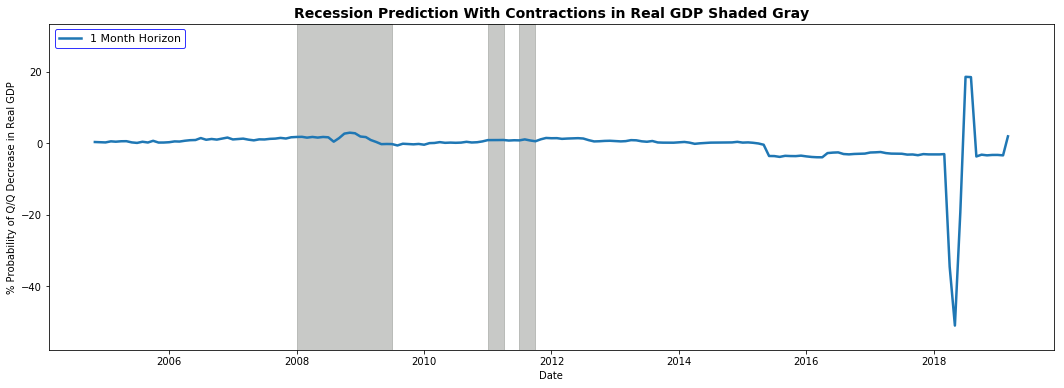

In [355]:
x = result1.index
a = result1.iloc[:,0]
b = result1.iloc[:,1]
c = result1.iloc[:,2]
d = result1.iloc[:,3]

fig, ax = plt.subplots(figsize=(18, 6))
#ax.plot(x, a, linewidth=2.5, zorder=2)
ax.plot(x, b, linewidth=2.5, zorder=2)
#ax.plot(x, c, linewidth=2.5, zorder=2)
#ax.plot(x, d, linewidth=2.5, zorder=2)
ax.scatter(x, a, s=0, zorder=1, label='_nolegend_')
ax.axvspan(x[38],x[56], color=sns.xkcd_rgb['grey'], alpha=0.5)
ax.axvspan(x[74],x[77], color=sns.xkcd_rgb['grey'], alpha=0.5)
ax.axvspan(x[80],x[83], color=sns.xkcd_rgb['grey'], alpha=0.5)

ax.set_title('Recession Prediction With Contractions in Real GDP Shaded Gray', fontsize=14, fontweight='demi')

ax.legend(loc='upper left', fontsize=11, frameon=True).get_frame().set_edgecolor('blue')

ax.set_ylabel('% Probability of Q/Q Decrease in Real GDP')
ax.set_xlabel('Date')

In [356]:
result1.tail()

,Current,1 Month Horizon,3 Mnth Hz,12 Mnth HZ
2018-11-01,-1.164277,-3.387512,-2.917165,12.661540
2018-12-01,-1.176262,-3.275871,-2.677531,12.531958
2019-01-01,-0.903869,-3.269371,-2.774579,12.696311
2019-02-01,-1.064250,-3.392303,-2.306870,12.619465
2019-03-01,1.867611,1.920992,-2.678155,14.767026
